In [1]:
import jsonlines
import os
import tqdm
import pandas as pd
import yaml
import matplotlib.pyplot as plt
import numpy as np
import sklearn.linear_model
import string
import torch
import transformers

pd.set_option('display.max_colwidth', None)

with open("config.yaml", "r") as fin:
    config = yaml.load(fin, Loader=yaml.FullLoader)

# Evaluation

In [11]:
policy_comps = [
    "refvsup+supvsup",
    "gpt2vgpt2d0.2",
    "refvgpt2d0.2",
    "refvgpt2",
    "refvmaskedrefprompt",
    "refvshuffledprompt",
    "gpt2vmaskedrefprompt",
    "gpt2vshuffledprompt",
    "gpt2vgpt2d0.2+refvmaskedrefprompt",
    "gpt2-xlvgpt2-xld0.2",
    "refvgpt2-xlmaskedrefprompt",
    "refvgpt2-xlmaskedprompt",
]
metrics = pd.DataFrame()
for dataset_name in ["tldr", "cnndm"]:
    for policy_comp in policy_comps:
        ns = ["1k", "5k", "10k", "20k", "30k", "40k"]
        for n in ns:
            for model in ["gpt2", "gpt2-xl"]:
                for test in ["tldr_refvsup+supvsup", "cnndm_supvsup", "cnndm_all"]:
                    experiment = "comparisons_" + dataset_name + "_" + policy_comp + "_train_" + model
                    if n:
                        experiment += "_n" + n
                    input_file = os.path.join(
                        config["models_dir"],
                        experiment,
                        "final_checkpoint",
                        "metrics_" + test + "_test.txt")
                    if not os.path.exists(input_file):
                        continue
                    m = pd.read_csv(input_file, header=None)
                    m.columns = ["metric", "value"]
                    m["dataset_name"] = dataset_name
                    m["policy_comp_name"] = policy_comp
                    m["n"] = n
                    m["model"] = model
                    m["test"] = test
                    metrics = metrics.append(m)
                    
                    
for policy_comp in ["pseudo10kgpt2-xln5k", "pseudo20kgpt2-xln5k", "pseudo30kgpt2-xln5k", "pseudo40kgpt2-xln5k"]:
    input_file = os.path.join(
        "/scratch/users/jakerochlinmarcus/data_synthesis/models/",
        "comparisons_tldr_" + policy_comp + "_train_gpt2-xl",
        "final_checkpoint",
        "metrics_tldr_refvsup+supvsup_test.txt")
    m = pd.read_csv(input_file, header=None)
    m.columns = ["metric", "value"]
    m["dataset_name"] = "tldr"
    n = policy_comp.replace("pseudo", "").replace("gpt2-xln5k", "")
    m["n"] = n
    m["policy_comp_name"] = policy_comp.replace(n, "")
    m["model"] = "gpt2-xl"
    m["test"] = "tldr_refvsup+supvsup"
    metrics = metrics.append(m)

,metric,value,dataset_name,policy_comp_name,n,model,test
1,acc,0.738846,tldr,refvsup+supvsup,30k,gpt2-xl,tldr_refvsup+supvsup
1,acc,0.736252,tldr,refvsup+supvsup,40k,gpt2-xl,tldr_refvsup+supvsup
1,acc,0.729716,tldr,refvsup+supvsup,20k,gpt2-xl,tldr_refvsup+supvsup
1,acc,0.701598,tldr,refvsup+supvsup,10k,gpt2-xl,tldr_refvsup+supvsup
1,acc,0.688421,tldr,pseudogpt2-xln5k,20k,gpt2-xl,tldr_refvsup+supvsup
1,acc,0.686346,tldr,pseudogpt2-xln5k,10k,gpt2-xl,tldr_refvsup+supvsup
1,acc,0.685931,tldr,pseudogpt2-xln5k,30k,gpt2-xl,tldr_refvsup+supvsup
1,acc,0.685412,tldr,pseudogpt2-xln5k,40k,gpt2-xl,tldr_refvsup+supvsup
1,acc,0.678668,tldr,refvgpt2-xlmaskedrefprompt,30k,gpt2-xl,tldr_refvsup+supvsup
1,acc,0.677526,tldr,refvgpt2-xlmaskedrefprompt,20k,gpt2-xl,tldr_refvsup+supvsup


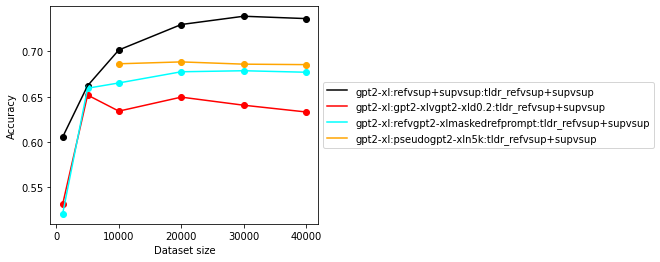

In [12]:
fig = plt.figure()
ax = plt.subplot(111)
policy_comp_name_to_specs = {
    "refvsup+supvsup": ("black", 1.0),
    "refvgpt2": ("green", 1.0),
    "refvgpt2d0.2": ("blue", 1.0),    
    "gpt2vgpt2d0.2": ("red", 1.0),
    "refvmaskedrefprompt": ("cyan", 1.0),
    "refvshuffledprompt": ("orange", 1.0),
    "gpt2vshuffledprompt": ("purple", 1.0),
    #"gpt2vgpt2d0.2+refvmaskedrefprompt": ("pink", 1.0)
    "gpt2-xlvgpt2-xld0.2": ("red", 1.0),
    "refvgpt2-xlmaskedrefprompt": ("cyan", 1.0),
    "refvgpt2-xlmaskedprompt": ("orange", 1.0),
    "pseudogpt2-xln5k": ("orange", 1.0),
}

test = "tldr_refvsup+supvsup"
#test = "cnndm_supvsup"
model = "gpt2-xl"
plot_metrics = pd.DataFrame()
colors = []
for policy_comp_name in policy_comp_name_to_specs:
    color, alpha = policy_comp_name_to_specs[policy_comp_name]
    f = (metrics["metric"] == "acc")
    f &= (metrics["policy_comp_name"] == policy_comp_name)
    f &= (metrics["test"] == test)
    f &= (metrics["model"] == model)
    f &= (metrics["n"].apply(lambda x: x is not None))
    x = [int(x.replace("k", "")) * 1000 for x in metrics[f]["n"].values]
    y = metrics[f]["value"]
    if len(x) == 0:
        continue
    ax.plot(x, y, label=model + ":" + policy_comp_name + ":" + test, color=color, alpha=alpha)
    ax.scatter(x, y, color=color)
    plot_metrics = plot_metrics.append(metrics[f])
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("Dataset size")
plt.ylabel("Accuracy")
plot_metrics.sort_values("value", ascending=False)

# Baseline: Logistic regression

In [8]:
def _longestRepeatedSubstring(str):
    # https://www.geeksforgeeks.org/longest-repeating-and-non-overlapping-substring/
    n = len(str)
    LCSRe = [[0 for x in range(n + 1)] for y in range(n + 1)]
    res = [] # To store result
    res_length = 0 # To store length of result
    # building table in bottom-up manner
    index = 0
    for i in range(1, n + 1):
        for j in range(i + 1, n + 1):
            if (str[i - 1] == str[j - 1] and LCSRe[i - 1][j - 1] < (j - i)):
                LCSRe[i][j] = LCSRe[i - 1][j - 1] + 1
                if (LCSRe[i][j] > res_length):
                    res_length = LCSRe[i][j]
                    index = max(i, index)
            else:
                LCSRe[i][j] = 0
    if (res_length > 0):
        for i in range(index - res_length + 1, index + 1):
            res.append(str[i - 1])
    return res

def featurize(completion):
    c = completion.lower()
    for punc in string.punctuation:
        c = c.replace(punc, " ")
    tokens = [x for x in c.split(" ") if x != ""]
    if len(tokens) == 0:
        prop_unique = 1
    else:
        prop_unique = len(set(tokens)) / len(tokens)
    features = {
        "len": len(completion),
        "capped_len": 200 if len(completion) >= 200 else len(completion),
        "prop_unique": prop_unique,
        "lcs": len(_longestRepeatedSubstring(tokens))
    }
    return features

X = []
y = []
splits = []
include_features = set(["capped_len"])
rows = []
for split in ["train", "test"]:
    if split == "train":
        f = os.path.join(config["data_dir"], "comparisons_tldr_refvsup+supvsup_train.jsonl")
    else:
        #f = os.path.join(config["data_dir"], "comparisons_tldr_refvsup+supvsup_test.jsonl")
        f = os.path.join(config["data_dir"], "comparisons_cnndm_supvsup_test.jsonl")
    with jsonlines.open(f, "r") as fin:
        for line in fin:
            assert line["completion0"].strip() == line["example"]["summaries"][0]["text"].strip()
            assert line["completion1"].strip() == line["example"]["summaries"][1]["text"].strip()
            row = {
                "completion0": line["completion0"],
                "completion1": line["completion1"],
                "note0": line["example"]["summaries"][0]["note"],
                "note1": line["example"]["summaries"][1]["note"],
                "choice": line["choice"],
                "split": split  
            }
            
            x0 = featurize(line["completion0"])
            x1 = featurize(line["completion1"])
            x = []
            for key in x0:
                diff = x1[key] - x0[key]
                if key in include_features:
                    x.append(diff)
                row["feature_" + key] = diff
            rows.append(row)
            X.append(x)
            y.append(line["choice"])
            splits.append(split)

df = pd.DataFrame.from_records(rows)
X = np.array(X)
y = np.array(y)
splits = np.array(splits)
n = len(X[splits == "train"])
for limit in [1000, 5000, n]: 
    model = sklearn.linear_model.LogisticRegression(C=1)
    model.fit(X[splits == "train"][:limit], y[splits == "train"][:limit])
    df["pred"] = model.predict(X)
    df["prob"] = model.predict_proba(X)[:, 1]
    acc = np.mean(df["pred"][df["split"] == "test"] == df["choice"][df["split"] == "test"])
    print((limit, acc))

(1000, 0.6141843971631206)
(5000, 0.6141843971631206)
(40843, 0.6092198581560284)


In [9]:
model.coef_

array([[0.0087013]])

# Policy composition

In [3]:
df = {
    "policyA": [],
    "policyB": [],
    "choiceAB": [],
    "prompt": [],
    "summaryA": [],
    "summaryB": [],
    "noteA": [],
    "noteB": [],
    "batch": [],
    "split": []
}
input_files = [
    "comparisons_tldr_all_train.jsonl",
    "comparisons_tldr_all_valid.jsonl",
    "comparisons_tldr_all_test.jsonl"
    #"comparisons_cnndm_all_test.jsonl"
]
for input_file in input_files:
    input_path = os.path.join(config["data_dir"], input_file)
    with jsonlines.open(input_path, "r") as fin:
        for line in tqdm.tqdm(fin):
            policy0 = line["example"]["summaries"][0]["policy"]
            policy1 = line["example"]["summaries"][1]["policy"]
            choice = line["choice"]
            assert line["example"]["summaries"][0]["text"].strip() == line["completion0"].strip()
            assert line["example"]["summaries"][1]["text"].strip() == line["completion1"].strip()
            if policy0 < policy1:
                policyA = policy0
                policyB = policy1
                choiceAB = line["choice"]
                summaryA = line["example"]["summaries"][0]["text"].strip()
                summaryB = line["example"]["summaries"][1]["text"].strip()
                noteA = line["example"]["summaries"][0]["note"]
                noteB = line["example"]["summaries"][1]["note"]
            else:
                policyA = policy1
                policyB = policy0
                choiceAB = 1 - line["choice"]
                summaryA = line["example"]["summaries"][1]["text"].strip()
                summaryB = line["example"]["summaries"][0]["text"].strip()
                noteA = line["example"]["summaries"][1]["note"]
                noteB = line["example"]["summaries"][0]["note"]
            df["policyA"].append(policyA)
            df["policyB"].append(policyB)
            df["choiceAB"].append(choiceAB)
            df["prompt"].append(line["prompt"])
            df["summaryA"].append(summaryA)
            df["summaryB"].append(summaryB)
            df["noteA"].append(noteA)
            df["noteB"].append(noteB)
            df["batch"].append(line["example"]["batch"])
            df["split"].append(line["example"]["split"])
df = pd.DataFrame(df)
df["n"] = 1

81622it [00:03, 23596.22it/s]
31963it [00:01, 23279.27it/s]
50709it [00:02, 23268.13it/s]


In [5]:
d = df.groupby(["policyA", "policyB"]).mean().reset_index().sort_values("choiceAB", ascending=False)
d = d[["policyA", "policyB", "choiceAB"]]
d2 = df.groupby(["policyA", "policyB"]).count().reset_index().sort_values("n", ascending=False)
d2 = d2[["policyA", "policyB", "n"]]
d = pd.merge(d, d2, on=["policyA", "policyB"])
d = d.sort_values("n", ascending=False)
f = [True] * len(d)
#f &= (d["policyA"].apply(lambda x: x.find("_ppo")) == -1)
#f &= (d["policyB"].apply(lambda x: x.find("_ppo")) == -1)
#f &= (d["policyA"].apply(lambda x: x.find("_bo")) == -1)
#f &= (d["policyB"].apply(lambda x: x.find("_bo")) == -1)
#f &= (d["policyA"] == "ref") & (d["policyB"].apply(lambda x: x.startswith("sup")))
#f &= (d["policyA"] == d["policyB"])
print(sum(d[f]["n"]))
d[f].sort_values("n", ascending=False)[0:20]

164294


,policyA,policyB,choiceAB,n
215,ref,sup2,0.265765,15224
121,sup2,sup2,0.490556,13289
112,sup4_ppo_rm3_kl20,sup4_ppo_rm3_kl20,0.503516,8391
129,sup4_ppo_rm3_kl10,sup4_ppo_rm3_kl10,0.479942,8251
114,sup4_6b_t0.7,sup4_6b_t0.7,0.501700,7353
229,ref,sup1,0.195642,6241
109,sup1,sup1,0.508786,6089
224,ref,sup4_t0.7,0.228566,4887
104,sup4_t0.7,sup4_t0.7,0.519783,4246
79,sup4_6b_ppo_rm3_6b_kl15,sup4_6b_ppo_rm4_6b_kl14,0.567659,2653


In [132]:
d = df.groupby(["policyA", "policyB", "split"]).sum().reset_index()
d = d[["policyA", "policyB", "split", "n"]]
d = d.sort_values("n", ascending=False)
d[0:20]

,policyA,policyB,split,n
97,ref,sup2,train,18065
245,sup2,sup2,train,16273
96,ref,sup1,train,7947
244,sup1,sup1,train,7653
383,sup4_ppo_rm3_kl10,sup4_ppo_rm3_kl10,train,6206
409,sup4_ppo_rm3_kl20,sup4_ppo_rm3_kl20,train,6098
340,sup4_6b_t0.7,sup4_6b_t0.7,train,5614
444,sup4_t0.7,sup4_t0.7,valid1,2785
410,sup4_ppo_rm3_kl20,sup4_ppo_rm3_kl20,valid1,2340
384,sup4_ppo_rm3_kl10,sup4_ppo_rm3_kl10,valid1,2070
